In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [11]:
for measurement in inspector.get_table_names():
   for column in inspector.get_columns(measurement):
       print("Column: %s" % column['name'])

Column: id
Column: station
Column: date
Column: prcp
Column: tobs
Column: id
Column: station
Column: name
Column: latitude
Column: longitude
Column: elevation


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Now calculate the Minumum date as 1 year less than the Current Max Date.
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
# Use Pandas Plotting with Matplotlib to plot the data
query = session.query(func.max(Measurement.date))
max_date = query.first()[0]

type(max_date)
max_date = dt.datetime.strptime(max_date, '%Y-%m-%d').date()
min_date = dt.date(max_date.year -1 , max_date.month, max_date.day)


prcip_query = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date.between(min_date, max_date))

df = pd.read_sql(prcip_query.statement, engine)

df = df.set_index("date")
df = df.sort_values(by=['date'])

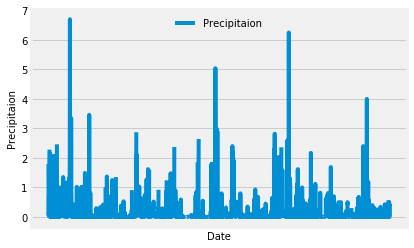

In [13]:
df.plot()
plt.xticks([])
plt.legend(['Precipitaion'], fontsize=10,framealpha=0, fancybox=True, loc=9)
plt.ylabel('Precipitaion', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.grid(axis='both',linewidth=1,linestyle='-')
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![precipitation](Images/precipitation.png)

![describe](Images/describe.png)

In [24]:
# Design a query to show how many stations are available in this dataset?

number_station = session.query(Station.station).distinct()
print(number_station.count())

9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station)\
                                           .desc()).all()
print(active_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most_active_id = session.query(Station.id).\
    filter(Station.station == active_station[0][0]).scalar()
active_query = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
                             func.avg(Measurement.tobs)).\
            filter(Measurement.station == active_station[0][0]).all()
print(active_query)

[(54.0, 85.0, 71.66378066378067)]


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(Measurement.tobs)\
    .filter(Measurement.station == active_station[0][0])\
    .filter(Measurement.date.between(min_date, max_date))
# temp = list(temp_query.all())
df2 = pd.read_sql(temp_query.statement, engine)
# print(temp)
df2_group = df2.groupby('tobs')

![precipitation](Images/station-histogram.png)

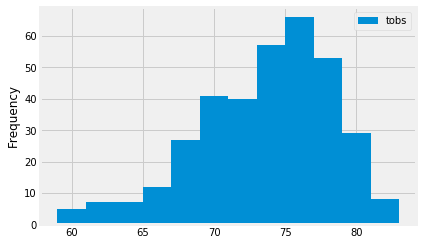

In [21]:
bins = 12
df2.plot(kind = 'hist', bins = bins)
plt.show()